In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Count

In [12]:
df_zonal = pd.read_parquet("../dataset/combined/zonal/australia.parquet")
df_zonal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1051855 entries, 0 to 1051854
Data columns (total 45 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   zone_id      1051855 non-null  int64         
 1   ts           1051855 non-null  datetime64[ns]
 2   sob_mean     1051855 non-null  float64       
 3   sob_sum      1051855 non-null  float64       
 4   o2_mean      1051855 non-null  float64       
 5   o2_sum       1051855 non-null  float64       
 6   uo_mean      1051855 non-null  float64       
 7   uo_sum       1051855 non-null  float64       
 8   chl_mean     1051855 non-null  float64       
 9   chl_sum      1051855 non-null  float64       
 10  dissic_mean  1051855 non-null  float64       
 11  dissic_sum   1051855 non-null  float64       
 12  thetao_mean  1051855 non-null  float64       
 13  thetao_sum   1051855 non-null  float64       
 14  wo_mean      1051855 non-null  float64       
 15  wo_sum       10

In [13]:
df_zonal["target"].value_counts()

target
0    1030904
1      20951
Name: count, dtype: int64

## Load Dataset

In [7]:
df_all = pd.read_parquet("../dataset/combined/train.parquet")
df_all.head()

,zone_id,ts,sob_mean,sob_sum,o2_mean,o2_sum,uo_mean,uo_sum,chl_mean,chl_sum,...,nppv_mean,nppv_sum,pbo_mean,pbo_sum,tob_mean,tob_sum,si_mean,si_sum,target,country
58033,710,2022-06-07,35.657410,570.518555,218.002274,436.004547,-0.038296,-0.612729,0.207091,0.414182,...,5.916996,11.833992,16.321039,261.136627,20.566235,329.059753,2.994500,5.989000,1,australia
4352,7238,2022-07-28,34.724483,416.693787,213.420013,426.840027,-0.339970,-4.079638,0.212763,0.425527,...,8.073357,16.146713,4563.563965,54762.769531,0.976179,11.714151,3.471707,6.943414,0,africa
31168,2339,2022-09-06,34.973125,419.677490,212.298492,212.298492,0.006893,0.082721,0.174526,0.174526,...,8.169475,8.169475,1187.816772,14253.801758,7.680325,92.163902,3.116743,3.116743,1,africa
65219,888,2022-08-26,34.678394,381.462341,216.173096,216.173096,-0.193235,-2.125590,0.240931,0.240931,...,10.960474,10.960474,432.666229,4759.328613,15.920063,175.120697,2.501924,2.501924,1,australia
1136,1991,2022-07-09,34.941536,314.473816,208.439087,208.439087,-0.204628,-1.841650,0.242374,0.242374,...,12.439981,12.439981,1454.521851,13090.696289,4.698487,42.286385,3.751432,3.751432,0,africa


In [8]:
df_all[["country", "target"]].value_counts()

country    target
africa     0         13776
           1         13776
australia  0         13776
           1         13776
Name: count, dtype: int64

## Information Gain

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, SelectPercentile, mutual_info_classif

In [9]:
X, y = df_all.drop(columns=["zone_id", "ts", "target", "country"]), df_all["target"]
# X, y = df_all[[col for col in df_all.columns if "mean" in col]], df_all["target"]

In [10]:
selector = SelectKBest(mutual_info_classif, k=10)
# selector = SelectPercentile(mutual_info_classif, percentile=10)
_ = selector.fit_transform(X, y)

In [11]:
pd.Series(selector.scores_, index=selector.feature_names_in_).sort_values(ascending=False).to_csv("infogain.csv")

In [12]:
selector.get_feature_names_out()

array(['sob_mean', 'sob_sum', 'fe_mean', 'fe_sum', 'so_sum', 'po4_mean',
       'pbo_mean', 'pbo_sum', 'tob_mean', 'tob_sum'], dtype=object)

- ALL: ['sob_mean', 'sob_sum', 'fe_mean', 'fe_sum', 'so_sum', 'po4_mean', 'pbo_mean', 'pbo_sum', 'tob_mean', 'tob_sum']
- MEANS: ['sob_mean', 'dissic_mean', 'fe_mean', 'phyc_mean', 'so_mean', 'po4_mean', 'nppv_mean', 'pbo_mean', 'tob_mean', 'si_mean']

In [31]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, matthews_corrcoef, ConfusionMatrixDisplay

In [17]:
X, y = df_all[["pbo_mean", "tob_mean", "sob_mean"]], df_all["target"]
stratify = df_all[["country", "target"]]

X_train, X_test, y_train, y_test =  train_test_split(X, y, stratify=stratify)

In [35]:
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)

KNeighborsClassifier()

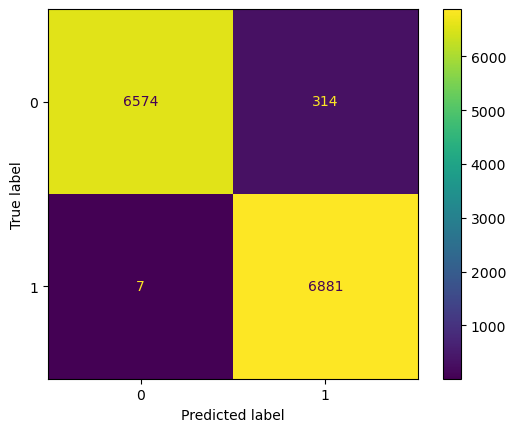

In [36]:
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)

In [37]:
y_pred = clf.predict(X_test)

print("MCC:", matthews_corrcoef(y_test, y_pred))
print(classification_report(y_test, y_pred))

MCC: 0.954345591684692
              precision    recall  f1-score   support

           0       1.00      0.95      0.98      6888
           1       0.96      1.00      0.98      6888

    accuracy                           0.98     13776
   macro avg       0.98      0.98      0.98     13776
weighted avg       0.98      0.98      0.98     13776

